In [1]:
%pip install matplotlib
%pip install shap


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import packages
import pandas as pd
import numpy as np
import datetime
import random
from sklearn.preprocessing import StandardScaler

In [3]:

def generate_dummy_data(
    n_rows=300,
    start_time="2025-01-07 1:00:00",
    interval_minutes=1,
    anomaly_rate=0.15,
    introduce_missing=False,
    missing_rate=0.01,
):
    """
    Generates dataset obeying strict thresholds:
      temp normal: 45-50 (inclusive) ; abnormal: >52 or <43
      pressure normal: 1.00-1.05 (inclusive) ; abnormal: >1.08 or <0.97
      vibration normal: 0.02-0.04 (inclusive) ; abnormal: >0.07
    label is set to 'abnormal' if any sensor is abnormal, else 'normal'.
    """
    start = datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
    timestamps = []
    temps = []
    pressures = []
    vibrations = []
    labels = []

    for i in range(n_rows):
        t = start + datetime.timedelta(minutes=interval_minutes * i)

        # By default produce normal readings
        temp = round(np.random.uniform(45.0, 50.0), 3)
        pressure = round(np.random.uniform(1.00, 1.05), 3)
        vibration = round(np.random.uniform(0.02, 0.04), 3)

        # Inject anomalies by picking sensors to be abnormal
        if random.random() < anomaly_rate:
            num_abnormals = random.choice([1, 2])
            sensors = random.sample(
                ["temp", "pressure", "vibration"], num_abnormals)
            for s in sensors:
                if s == "temp":
                    if random.random() < 0.5:
                        temp = round(np.random.uniform(
                            30.000, 42.999), 1)  # <43
                    else:
                        temp = round(np.random.uniform(
                            52.001, 70.000), 1)  # >52
                elif s == "pressure":
                    if random.random() < 0.5:
                        pressure = round(np.random.uniform(
                            0.80, 0.969), 3)  # <0.97
                    else:
                        pressure = round(np.random.uniform(
                            1.081, 1.30), 3)  # >1.08
                else:  # vibration
                    vibration = round(np.random.uniform(
                        0.071, 0.300), 3)  # >0.07

        # Decide label strictly from sensor thresholds
        is_abnormal = (
            (temp > 52.0 or temp < 43.0) or
            (pressure > 1.08 or pressure < 0.97) or
            (vibration > 0.07)
        )
        label = "abnormal" if is_abnormal else "normal"

        timestamps.append(t)
        temps.append(temp)
        pressures.append(pressure)
        vibrations.append(vibration)
        labels.append(label)

    df = pd.DataFrame({
        "timestamp": timestamps,
        "temp": temps,
        "pressure": pressures,
        "vibration": vibrations,
        "label": labels
    })

    # some missing values to test preprocessing
    if introduce_missing and missing_rate > 0:
        n_cells = df.shape[0] * 3  # only sensor columns
        n_missing = int(n_cells * missing_rate)
        for _ in range(n_missing):
            ridx = random.randrange(df.shape[0])
            col = random.choice(["temp", "pressure", "vibration"])
            df.at[ridx, col] = np.nan

    return df


df = generate_dummy_data(n_rows=150, interval_minutes=5,
                         anomaly_rate=0.15, introduce_missing=True)
print(df.head(8))
print("\nSummary counts:", df['label'].value_counts())

            timestamp    temp  pressure  vibration   label
0 2025-01-07 01:00:00  49.711     1.000      0.040  normal
1 2025-01-07 01:05:00  48.520     1.026      0.027  normal
2 2025-01-07 01:10:00  45.556     1.040      0.039  normal
3 2025-01-07 01:15:00  49.261     1.029      0.033  normal
4 2025-01-07 01:20:00  47.474     1.050      0.025  normal
5 2025-01-07 01:25:00  45.092     1.044      0.036  normal
6 2025-01-07 01:30:00  45.203     1.012      0.022  normal
7 2025-01-07 01:35:00  49.882     1.008      0.029  normal

Summary counts: label
normal      121
abnormal     29
Name: count, dtype: int64


In [4]:
print("Missing values per column:")
print(df.isnull().sum())
# forward fill
df.ffill()

Missing values per column:
timestamp    0
temp         0
pressure     2
vibration    2
label        0
dtype: int64


,timestamp,temp,pressure,vibration,label
0,2025-01-07 01:00:00,49.711,1.000,0.040,normal
1,2025-01-07 01:05:00,48.520,1.026,0.027,normal
2,2025-01-07 01:10:00,45.556,1.040,0.039,normal
3,2025-01-07 01:15:00,49.261,1.029,0.033,normal
4,2025-01-07 01:20:00,47.474,1.050,0.025,normal
...,...,...,...,...,...
145,2025-01-07 13:05:00,49.735,1.003,0.037,normal
146,2025-01-07 13:10:00,48.560,1.048,0.037,normal
147,2025-01-07 13:15:00,47.652,1.044,0.037,normal
148,2025-01-07 13:20:00,45.174,1.013,0.037,normal


In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import shap
import numpy as np

# Prepare data
X = df[["temp", "pressure", "vibration"]].copy()
y = df["label"].map({"normal": 0, "abnormal": 1}).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train on first 50 rows
X_train = X_scaled[:50]
y_train = y.iloc[:50]

# Predict on all rows
X_eval = X_scaled

clf = RandomForestClassifier(
    n_estimators=100,
    random_state=50,
    class_weight="balanced",
)
clf.fit(X_train, y_train)

df["ml_pred"] = clf.predict(X_eval)
df["ml_score"] = clf.predict_proba(X_eval)[:, 1]

ml_anomalies = df[df["ml_pred"] == 1].copy()
print(f"ML Anomalies detected by RandomForest: {len(ml_anomalies)}")
# ----------------------
# SHAP explanation (robust across SHAP versions)
# ----------------------
# Use TreeExplainer and the new callable API
explainer = shap.TreeExplainer(clf, data=X_train, model_output="probability")

# indices of rows predicted as abnormal
ml_idx = np.where(df["ml_pred"].values == 1)[0]

if len(ml_idx) == 0:
    # no ML anomalies -> empty explanation column on ml_anomalies
    ml_anomalies["ml_explanation"] = ""
else:
    # subset the evaluation matrix for only the ML-anomalous rows
    X_eval_abn = X_eval[ml_idx]

    # get SHAP Explanation for the abnormal subset
    shap_exp_abn = explainer(X_eval_abn)
    shap_values = shap_exp_abn.values
    shap_values = np.asarray(shap_values)
    shap_for_pos = shap_values[:, :, 1]

    feature_names = ["temp", "pressure", "vibration"]

    def shap_reason_from_array(row_shap):
        # only keep features that *increase* the probability (shap > 0)
       
        contributions = [
            f
            for f, v in zip(feature_names, row_shap)
            if v > 0.1
        ]
        return "; ".join(contributions) if contributions else "Unclear"

    # build explanations for the anomalous subset in the original order
    explanations = [shap_reason_from_array(row_shap) for row_shap in shap_for_pos]

    # attach explanations to ml_anomalies (preserving its index)
    ml_anomalies = ml_anomalies.reset_index(drop=False)  
    # find mapping from df index to position in ml_idx
    df_index_to_pos = {orig_idx: pos for pos, orig_idx in enumerate(ml_idx)}
    # create explanation column aligned to ml_anomalies rows
    ml_expl_col = []
    for orig_idx in ml_anomalies["index"].values:
        pos = df_index_to_pos.get(orig_idx)
        ml_expl_col.append(explanations[pos] if pos is not None else "")

    ml_anomalies["ml_explanation"] = ml_expl_col
    ml_anomalies = ml_anomalies.drop(columns=["index"]).set_index(df.index.name if df.index.name is not None else None, drop=True) if False else ml_anomalies  # keep simple copy

print(ml_anomalies.head())

/Users/jeremy/Desktop/pegatron/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ML Anomalies detected by RandomForest: 23
   index           timestamp    temp  pressure  vibration     label  ml_pred  \
0     11 2025-01-07 01:55:00  47.804     1.002      0.270  abnormal        1   
1     16 2025-01-07 02:20:00  47.784     1.229      0.098  abnormal        1   
2     17 2025-01-07 02:25:00  53.000     1.034      0.038  abnormal        1   
3     25 2025-01-07 03:05:00  67.200     1.009      0.186  abnormal        1   
4     32 2025-01-07 03:40:00  45.205     0.839      0.033  abnormal        1   

   ml_score       ml_explanation  
0      0.90            vibration  
1      0.70  pressure; vibration  
2      0.64                 temp  
3      0.96      temp; vibration  
4      0.71             pressure  


In [6]:
def anomaly_score(temp, pressure, vibration):
    score = 0.0

    # Temperature
    if temp > 52:
        score += (temp - 52)
    elif temp < 43:
        score += (43 - temp)

    # Pressure
    if pressure > 1.08:
        score += (pressure - 1.08) * 10
    elif pressure < 0.97:
        score += (0.97 - pressure) * 10

    # Vibration
    if vibration > 0.07:
        score += (vibration - 0.07) * 100

    return round(score, 4)


def detect_anomalies(row):
    reasons = []
    if row["temp"] > 52 or row["temp"] < 43:
        reasons.append(f"Temperature out of range ({row['temp']}°C)")
    if row["pressure"] > 1.08 or row["pressure"] < 0.97:
        reasons.append(f"Pressure out of range ({row['pressure']} bar)")
    if row["vibration"] > 0.07:
        reasons.append(f"High vibration ({row['vibration']})")
    return reasons


alerts = []
for idx, row in df.iterrows():
    reasons = detect_anomalies(row)
    if reasons:
        alerts.append({
            "timestamp": row["timestamp"],
            "temp": row["temp"],
            "pressure": row["pressure"],
            "vibration": row["vibration"],
            "score": anomaly_score(row["temp"], row["pressure"], row["vibration"]),
            "alert_reasons": "; ".join(reasons),
        })

rule_anomalies = pd.DataFrame(alerts)
print(f"Anomalies detected by rules: {len(rule_anomalies)}")
print(rule_anomalies.head())

Anomalies detected by rules: 29
            timestamp    temp  pressure  vibration  score  \
0 2025-01-07 01:55:00  47.804     1.002      0.270  20.00   
1 2025-01-07 02:20:00  47.784     1.229      0.098   4.29   
2 2025-01-07 02:25:00  53.000     1.034      0.038   1.00   
3 2025-01-07 03:05:00  67.200     1.009      0.186  26.80   
4 2025-01-07 03:40:00  45.205     0.839      0.033   1.31   

                                       alert_reasons  
0                              High vibration (0.27)  
1  Pressure out of range (1.229 bar); High vibrat...  
2                  Temperature out of range (53.0°C)  
3  Temperature out of range (67.2°C); High vibrat...  
4                  Pressure out of range (0.839 bar)  


In [7]:
def build_combined_alerts(df_rule, df_ml):
    # Ensure timestamps are datetime
    df_rule["timestamp"] = pd.to_datetime(df_rule["timestamp"])
    df_ml["timestamp"] = pd.to_datetime(df_ml["timestamp"])

    # Calculate rule scores
    df_rule["rule_score"] = df_rule.apply(
        lambda row: anomaly_score(
            row["temp"], row["pressure"], row["vibration"]),
        axis=1
    )

    rule_min = df_rule["rule_score"].min()
    rule_max = df_rule["rule_score"].max()

    df_rule["rule_score"] = (df_rule["rule_score"] - rule_min) / (rule_max - rule_min) # normalize rule score

    # Add source flags
    df_rule_alerts = df_rule.copy()
    df_rule_alerts["rule"] = True
    df_rule_alerts["ml"] = False

    df_ml_alerts = df_ml.copy()
    df_ml_alerts = df_ml_alerts.rename(columns={"anomaly_score": "ml_score"})
    df_ml_alerts["rule"] = False
    df_ml_alerts["ml"] = True

    # Merge outer join on timestamp
    merged = pd.merge(
        df_rule_alerts,
        df_ml_alerts,
        on="timestamp",
        how="outer",
        suffixes=("_rule", "_ml")
    )

    # Flags
    merged["rule"] = merged["rule_rule"].fillna(False)
    merged["ml"] = merged["ml_ml"].fillna(False)

    # Combine values for display (prefer rule values if available)
    merged["temp"] = merged["temp_rule"].combine_first(merged["temp_ml"])
    merged["pressure"] = merged["pressure_rule"].combine_first(
        merged["pressure_ml"])
    merged["vibration"] = merged["vibration_rule"].combine_first(
        merged["vibration_ml"])

    # Alert text
    merged["alert_reasons"] = merged["alert_reasons"].fillna("")
    merged["ml_explanation"] = merged["ml_explanation"].fillna("")
    # Keep relevant columns
    merged = merged[[
        "timestamp", "temp", "pressure", "vibration",
        "rule", "ml", "rule_score", "ml_score",
        "alert_reasons", "ml_explanation"
    ]]

    return merged.sort_values("timestamp").reset_index(drop=True)


def combined_alerts(merged_alerts):
    print(f"\n===============================")
    print(f"      ANOMALY ALERT AGENT")
    print(f"===============================")
    print(f"Total anomalies: {len(merged_alerts)}")
    print(
        f"Rule-based: {merged_alerts['rule'].sum()} | ML-based: {merged_alerts['ml'].sum()}\n")

    for _, row in merged_alerts.iterrows():
        # Detection source label
        if row["rule"] and row["ml"]:
            source = "Both Rule-based and ML-based"
        elif row["rule"]:
            source = "Rule-based"
        else:
            source = "ML-based"

        print(f"[{row['timestamp']}] ALERT ({source})")
        print(
            f"Temp={row['temp']:.2f}°C | Pressure={row['pressure']:.2f} | Vibration={row['vibration']:.3f}")

        # Show scores & suggestions
        if pd.notna(row.get("rule_score")):
            print(f"Rule Score: {row['rule_score']:.4f}")
            if isinstance(row.get("alert_reasons"), str) and row["alert_reasons"]:
                print(f"Reasons: {row['alert_reasons']}")

        if pd.notna(row.get("ml_score")):
            print(f"ML Anomaly Score: {row['ml_score']:.4f}")
            print(
                f"ML Suggestion: Abnormal {row['ml_explanation']}")

        print("-" * 70)


merged_alerts = build_combined_alerts(rule_anomalies, ml_anomalies)
combined_alerts(merged_alerts)


      ANOMALY ALERT AGENT
Total anomalies: 29
Rule-based: 29 | ML-based: 23

[2025-01-07 01:55:00] ALERT (Both Rule-based and ML-based)
Temp=47.80°C | Pressure=1.00 | Vibration=0.270
Rule Score: 0.7444
Reasons: High vibration (0.27)
ML Anomaly Score: 0.9000
ML Suggestion: Abnormal vibration
----------------------------------------------------------------------
[2025-01-07 02:20:00] ALERT (Both Rule-based and ML-based)
Temp=47.78°C | Pressure=1.23 | Vibration=0.098
Rule Score: 0.1538
Reasons: Pressure out of range (1.229 bar); High vibration (0.098)
ML Anomaly Score: 0.7000
ML Suggestion: Abnormal pressure; vibration
----------------------------------------------------------------------
[2025-01-07 02:25:00] ALERT (Both Rule-based and ML-based)
Temp=53.00°C | Pressure=1.03 | Vibration=0.038
Rule Score: 0.0301
Reasons: Temperature out of range (53.0°C)
ML Anomaly Score: 0.6400
ML Suggestion: Abnormal temp
----------------------------------------------------------------------
[2025-01-07

/var/folders/40/s9_zmr095ljbsmd_5bk0rf4w0000gn/T/ipykernel_7384/1365196471.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["ml"] = merged["ml_ml"].fillna(False)


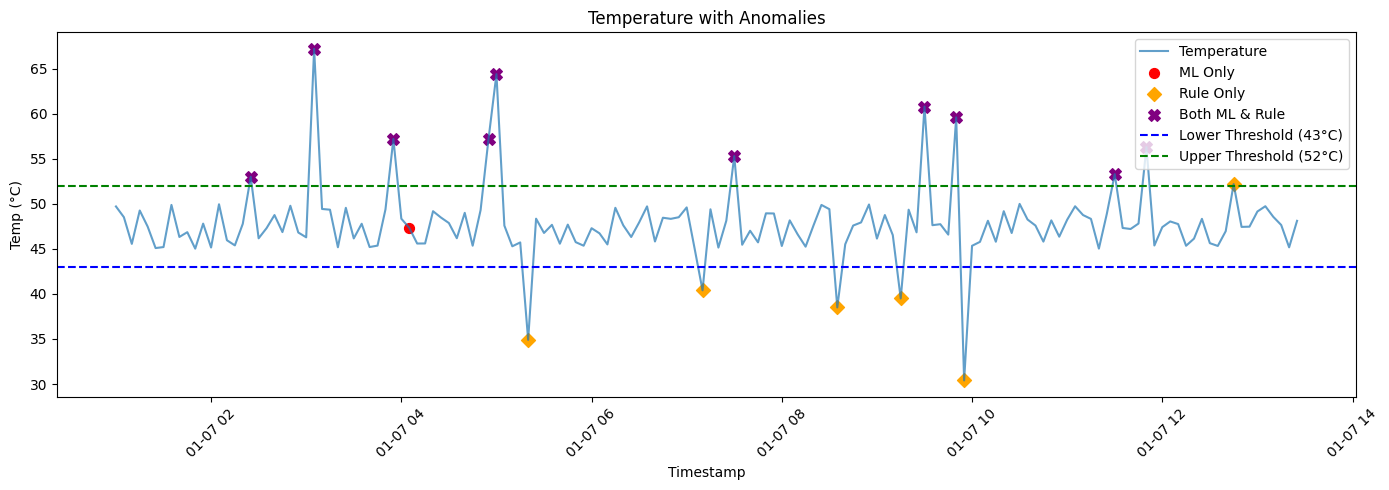

In [8]:
import matplotlib.pyplot as plt

df["rule_temperature_anomaly"] = df["timestamp"].isin(
    rule_anomalies.loc[rule_anomalies["alert_reasons"].str.contains("Temperature", na=False), "timestamp"]
)
df["ml_temperature_anomaly"] = df["timestamp"].isin(
    ml_anomalies.loc[ml_anomalies["ml_explanation"].str.contains("temp", na=False), "timestamp"]
)
# Masks
both_mask = df["ml_temperature_anomaly"] & df["rule_temperature_anomaly"]
ml_only_mask = df["ml_temperature_anomaly"] & (~df["rule_temperature_anomaly"])
rule_only_mask = (~df["ml_temperature_anomaly"]) & df["rule_temperature_anomaly"]

plt.figure(figsize=(14, 5))
plt.plot(df["timestamp"], df["temp"], label="Temperature", alpha=0.7)

# Plot anomalies
plt.scatter(df["timestamp"][ml_only_mask], df["temp"][ml_only_mask],
            color="red", label="ML Only", s=50, marker="o")
plt.scatter(df["timestamp"][rule_only_mask], df["temp"][rule_only_mask],
            color="orange", label="Rule Only", s=50, marker="D")
plt.scatter(df["timestamp"][both_mask], df["temp"][both_mask],
            color="purple", label="Both ML & Rule", s=70, marker="X")

plt.axhline(y=43, color='blue', linestyle='--', label='Lower Threshold (43°C)')
plt.axhline(y=52, color='green', linestyle='--', label='Upper Threshold (52°C)')

plt.title("Temperature with Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Temp (°C)")
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

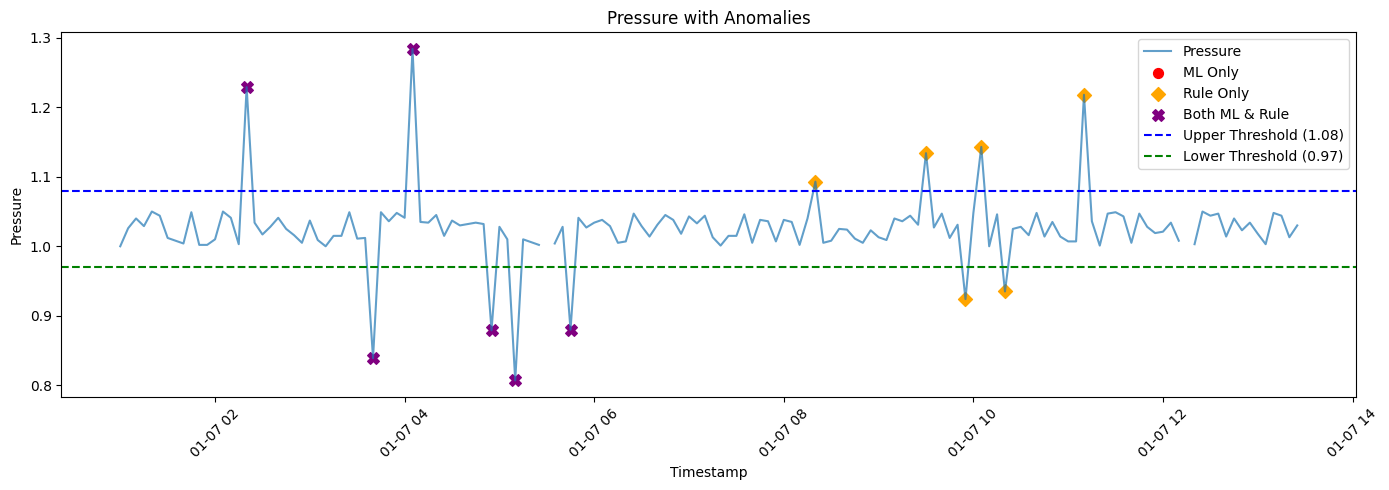

In [9]:
df["rule_pressure_anomaly"] = df["timestamp"].isin(
    rule_anomalies.loc[rule_anomalies["alert_reasons"].str.contains("Pressure", na=False), "timestamp"]
)
df["ml_pressure_anomaly"] = df["timestamp"].isin(
    ml_anomalies.loc[ml_anomalies["ml_explanation"].str.contains("pressure", na=False), "timestamp"]
)
# Masks
both_mask = df["ml_pressure_anomaly"] & df["rule_pressure_anomaly"]
ml_only_mask = df["ml_pressure_anomaly"] & (~df["rule_pressure_anomaly"])
rule_only_mask = (~df["ml_pressure_anomaly"]) & df["rule_pressure_anomaly"]

plt.figure(figsize=(14, 5))
plt.plot(df["timestamp"], df["pressure"], label="Pressure", alpha=0.7)

# Plot anomalies
plt.scatter(df["timestamp"][ml_only_mask], df["pressure"][ml_only_mask],
            color="red", label="ML Only", s=50, marker="o")
plt.scatter(df["timestamp"][rule_only_mask], df["pressure"][rule_only_mask],
            color="orange", label="Rule Only", s=50, marker="D")
plt.scatter(df["timestamp"][both_mask], df["pressure"][both_mask],
            color="purple", label="Both ML & Rule", s=70, marker="X")

plt.axhline(y=1.08, color='blue', linestyle='--', label='Upper Threshold (1.08)')
plt.axhline(y=0.97, color='green', linestyle='--', label='Lower Threshold (0.97)')

plt.title("Pressure with Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Pressure")
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

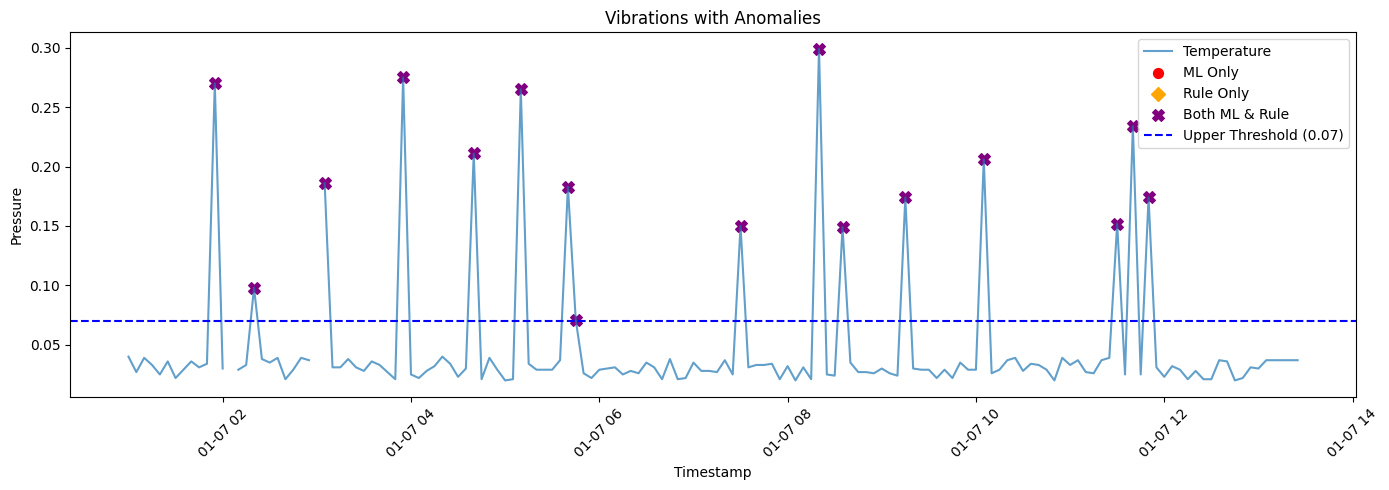

In [10]:
df["rule_vibration_anomaly"] = df["timestamp"].isin(
    rule_anomalies.loc[rule_anomalies["alert_reasons"].str.contains("vibration", na=False), "timestamp"]
)
df["ml_vibration_anomaly"] = df["timestamp"].isin(
    ml_anomalies.loc[ml_anomalies["ml_explanation"].str.contains("vibration", na=False), "timestamp"]
)
# Masks
both_mask = df["ml_vibration_anomaly"] & df["rule_vibration_anomaly"]
ml_only_mask = df["ml_vibration_anomaly"] & (~df["rule_vibration_anomaly"])
rule_only_mask = (~df["ml_vibration_anomaly"]) & df["rule_vibration_anomaly"]

plt.figure(figsize=(14, 5))
plt.plot(df["timestamp"], df["vibration"], label="Temperature", alpha=0.7)

# Plot anomalies
plt.scatter(df["timestamp"][ml_only_mask], df["vibration"][ml_only_mask],
            color="red", label="ML Only", s=50, marker="o")
plt.scatter(df["timestamp"][rule_only_mask], df["vibration"][rule_only_mask],
            color="orange", label="Rule Only", s=50, marker="D")
plt.scatter(df["timestamp"][both_mask], df["vibration"][both_mask],
            color="purple", label="Both ML & Rule", s=70, marker="X")
plt.axhline(y=0.07, color='blue', linestyle='--', label='Upper Threshold (0.07)')

plt.title("Vibrations with Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Pressure")
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()